In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
%matplotlib inline

In [2]:
os.chdir("C:\\Users\\GL75\\OneDrive\\桌面\\深度學習\\Lab2")

In [3]:
from dataloader import read_bci_data

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device = {device}")

device = cuda


In [6]:
X_train, y_train, X_test, y_test = read_bci_data()

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


In [7]:
batch_size = 270

In [3]:
lr = 0.001
epochs = 300

In [9]:
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

sample from training data: id = 861


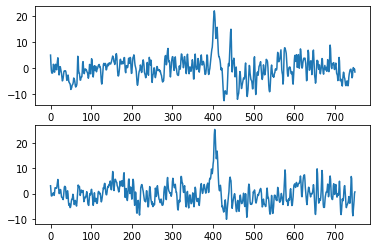

In [11]:
random_num = np.random.randint(0, X_train.shape[0])
print("sample from training data: id = {}".format(random_num))
plt.subplot(211)
plt.plot(X_train[random_num, 0, 0])
plt.subplot(212)
plt.plot(X_train[random_num, 0, 1])

In [4]:
class EEGNet(nn.Module):
    def __init__(self, activation_fn = nn.ELU()):
        super().__init__()
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = (1, 51), stride = (1, 1), padding = (0, 25), bias = False),
            nn.BatchNorm2d(16, eps = 1e-5, momentum = 0.1, affine = True, track_running_stats = True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size = (2, 1), stride = (1, 1), groups = 16, bias = False), # input channels = groups, meaning depthwise, a channel a filter
            nn.BatchNorm2d(32, eps = 1e-5, momentum = 0.1, affine = True, track_running_stats = True),
            activation_fn,
            nn.AvgPool2d(kernel_size = (1, 4), stride = (1, 4), padding = 0),
            nn.Dropout(p = 0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size = (1, 15), stride = (1, 1), padding = (0, 7), bias = False),
            nn.BatchNorm2d(32, eps = 1e-5, momentum = 0.1, affine = True, track_running_stats = True),
            activation_fn,
            nn.AvgPool2d(kernel_size = (1, 8), stride = (1, 8), padding = 0),
            nn.Dropout(p = 0.25)
        )
        self.flatten = nn.Flatten()
        self.classify = nn.Linear(736, 2)
    def forward(self, X):
        output = self.firstconv(X)
        output = self.depthwiseConv(output)
        output = self.separableConv(output)
        output = self.flatten(output)
        output = self.classify(output)
        return output

In [13]:
loss_fn = nn.CrossEntropyLoss()

In [14]:
accuracy_list = dict()
accuracy_list['epoch'] = list(range(1, epochs + 1))

In [15]:
def testing(model, test_dataloader, device):
    model.eval()
    accuracy = 0.0
    with torch.no_grad():
        for (X_batched, y_batched) in test_dataloader:
            X_batched = X_batched.to(device, dtype = torch.float)
            y_batched = y_batched.to(device, dtype = torch.long)
            prediction = model(X_batched)
            accuracy += prediction.max(dim = 1)[1].eq(y_batched).sum().item()
        accuracy = accuracy / len(test_dataloader.dataset) * 100
    return accuracy

In [16]:
def training(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs, device):
    train_acc, test_acc = [], []
    best_test_acc = 0.0
    best_model_weights = None
    for e in range(epochs):
        '''training session'''
        model.train()
        train_loss = 0.0
        accuracy = 0.0
        for (X_batched, y_batched) in train_dataloader:
            optimizer.zero_grad()
            X_batched = X_batched.to(device, dtype = torch.float)
            y_batched = y_batched.to(device, dtype = torch.long)
            prediction = model(X_batched)
            loss = loss_fn(prediction, y_batched)
            train_loss += loss.item()
            accuracy += prediction.max(dim = 1)[1].eq(y_batched).sum().item()
            loss.backward()
            optimizer.step()
        train_loss /= len(train_dataloader.dataset)
        accuracy = accuracy / len(train_dataloader.dataset) * 100
        if (e+1) % 10 == 0:
            print(f"Epoch {e+1:>3d}: loss = {train_loss:.5f}, acc = {accuracy:.2f}%")
        train_acc.append(accuracy)
        '''testing session'''
        accuracy = testing(model, test_dataloader, device)
        test_acc.append(accuracy)
        if accuracy > best_test_acc:
            best_test_acc = accuracy
            best_model_weights = copy.deepcopy(model.state_dict())
    return train_acc, test_acc, best_model_weights

# ELU (default)

In [7]:
model = EEGNet()
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr = lr)

In [8]:
print(model)

EEGNet(
  (firstconv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwiseConv): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (separableConv): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classify): Linear(in_features=736, out_features=2, bias=Tru

In [18]:
train_acc, test_acc, best_model_weights = training(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs, device)
accuracy_list['ELU_train'] = train_acc
accuracy_list['ELU_test'] = test_acc
torch.save(best_model_weights, os.path.join("D://DL_lab2_params/EEGNet", "ELU.pt"))

Epoch  10: loss = 0.00177, acc = 76.39%
Epoch  20: loss = 0.00160, acc = 78.98%
Epoch  30: loss = 0.00149, acc = 80.93%
Epoch  40: loss = 0.00135, acc = 83.98%
Epoch  50: loss = 0.00124, acc = 85.83%
Epoch  60: loss = 0.00106, acc = 88.24%
Epoch  70: loss = 0.00093, acc = 89.54%
Epoch  80: loss = 0.00089, acc = 90.19%
Epoch  90: loss = 0.00082, acc = 91.11%
Epoch 100: loss = 0.00083, acc = 90.56%
Epoch 110: loss = 0.00071, acc = 92.96%
Epoch 120: loss = 0.00067, acc = 92.78%
Epoch 130: loss = 0.00057, acc = 94.54%
Epoch 140: loss = 0.00062, acc = 93.43%
Epoch 150: loss = 0.00051, acc = 95.28%
Epoch 160: loss = 0.00058, acc = 94.44%
Epoch 170: loss = 0.00048, acc = 95.09%
Epoch 180: loss = 0.00049, acc = 94.91%
Epoch 190: loss = 0.00045, acc = 95.83%
Epoch 200: loss = 0.00042, acc = 96.11%
Epoch 210: loss = 0.00034, acc = 96.94%
Epoch 220: loss = 0.00037, acc = 96.67%
Epoch 230: loss = 0.00030, acc = 97.69%
Epoch 240: loss = 0.00028, acc = 98.06%
Epoch 250: loss = 0.00029, acc = 97.31%


# ReLU

In [19]:
model = EEGNet(activation_fn = nn.ReLU())
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr = lr)

In [20]:
train_acc, test_acc, best_model_weights = training(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs, device)
accuracy_list["ReLU_train"] = train_acc
accuracy_list["ReLU_test"] = test_acc
torch.save(best_model_weights, os.path.join("D://DL_lab2_params/EEGNet", "ReLU.pt"))

Epoch  10: loss = 0.00178, acc = 76.02%
Epoch  20: loss = 0.00161, acc = 79.72%
Epoch  30: loss = 0.00147, acc = 81.48%
Epoch  40: loss = 0.00122, acc = 86.67%
Epoch  50: loss = 0.00111, acc = 87.87%
Epoch  60: loss = 0.00094, acc = 89.81%
Epoch  70: loss = 0.00082, acc = 91.76%
Epoch  80: loss = 0.00076, acc = 92.41%
Epoch  90: loss = 0.00063, acc = 93.61%
Epoch 100: loss = 0.00058, acc = 94.63%
Epoch 110: loss = 0.00052, acc = 95.19%
Epoch 120: loss = 0.00047, acc = 95.65%
Epoch 130: loss = 0.00041, acc = 96.20%
Epoch 140: loss = 0.00039, acc = 96.57%
Epoch 150: loss = 0.00039, acc = 96.30%
Epoch 160: loss = 0.00036, acc = 97.13%
Epoch 170: loss = 0.00037, acc = 96.57%
Epoch 180: loss = 0.00029, acc = 97.96%
Epoch 190: loss = 0.00031, acc = 97.50%
Epoch 200: loss = 0.00030, acc = 97.13%
Epoch 210: loss = 0.00025, acc = 98.06%
Epoch 220: loss = 0.00024, acc = 98.15%
Epoch 230: loss = 0.00026, acc = 97.50%
Epoch 240: loss = 0.00023, acc = 98.33%
Epoch 250: loss = 0.00021, acc = 98.43%


# LeakyReLU

In [21]:
model = EEGNet(activation_fn = nn.LeakyReLU())
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr = lr)

In [22]:
train_acc, test_acc, best_model_weights = training(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs, device)
accuracy_list["LeakyReLU_train"] = train_acc
accuracy_list["LeakyReLU_test"] = test_acc
torch.save(best_model_weights, os.path.join("D://DL_lab2_params/EEGNet", "LeakyReLU.pt"))

Epoch  10: loss = 0.00173, acc = 76.67%
Epoch  20: loss = 0.00155, acc = 80.19%
Epoch  30: loss = 0.00131, acc = 85.93%
Epoch  40: loss = 0.00106, acc = 87.96%
Epoch  50: loss = 0.00087, acc = 90.65%
Epoch  60: loss = 0.00079, acc = 91.76%
Epoch  70: loss = 0.00064, acc = 93.24%
Epoch  80: loss = 0.00054, acc = 95.37%
Epoch  90: loss = 0.00052, acc = 95.19%
Epoch 100: loss = 0.00048, acc = 95.65%
Epoch 110: loss = 0.00045, acc = 96.02%
Epoch 120: loss = 0.00045, acc = 95.93%
Epoch 130: loss = 0.00037, acc = 96.30%
Epoch 140: loss = 0.00035, acc = 96.67%
Epoch 150: loss = 0.00042, acc = 95.56%
Epoch 160: loss = 0.00030, acc = 97.04%
Epoch 170: loss = 0.00027, acc = 97.69%
Epoch 180: loss = 0.00025, acc = 97.87%
Epoch 190: loss = 0.00024, acc = 98.52%
Epoch 200: loss = 0.00030, acc = 97.59%
Epoch 210: loss = 0.00021, acc = 98.24%
Epoch 220: loss = 0.00021, acc = 98.61%
Epoch 230: loss = 0.00023, acc = 98.06%
Epoch 240: loss = 0.00027, acc = 97.31%
Epoch 250: loss = 0.00029, acc = 97.04%


In [23]:
df_acc = pd.DataFrame(accuracy_list)

In [24]:
for col in df_acc.columns[1: ]:
    print("The maximum {}ing accuracy of the model using {} is: {:.2f}%".format(col.split("_")[1], col.split("_")[0], df_acc[col].max()))

The maximum training accuracy of the model using ELU is: 98.52%
The maximum testing accuracy of the model using ELU is: 82.31%
The maximum training accuracy of the model using ReLU is: 98.80%
The maximum testing accuracy of the model using ReLU is: 86.30%
The maximum training accuracy of the model using LeakyReLU is: 98.70%
The maximum testing accuracy of the model using LeakyReLU is: 87.31%


In [25]:
activation = {"ELU.pt": nn.ELU(), "ReLU.pt": nn.ReLU(), "LeakyReLU.pt": nn.LeakyReLU()}
for param_file in os.listdir("D://DL_lab2_params/EEGNet"):
    model = EEGNet(activation[param_file])
    model.load_state_dict(torch.load(os.path.join("D://DL_lab2_params/EEGNet", param_file), map_location = device))
    model.to(device)
    acc = testing(model, test_dataloader, device)
    print(f"The testing accuracy of the model using {param_file[:-3]} is: {acc:.2f}%")

The testing accuracy of the model using ELU is: 82.31%
The testing accuracy of the model using LeakyReLU is: 87.31%
The testing accuracy of the model using ReLU is: 86.30%


In [26]:
def plot_result(df):
    fig = plt.figure(figsize = (15, 10))
    for config in df.columns[1:]:
        plt.plot(df.columns[0], config, data = df)
    plt.legend()
    plt.title("Comparison Figure (via Accuracy)")
    plt.savefig("EEGNet_result.png")

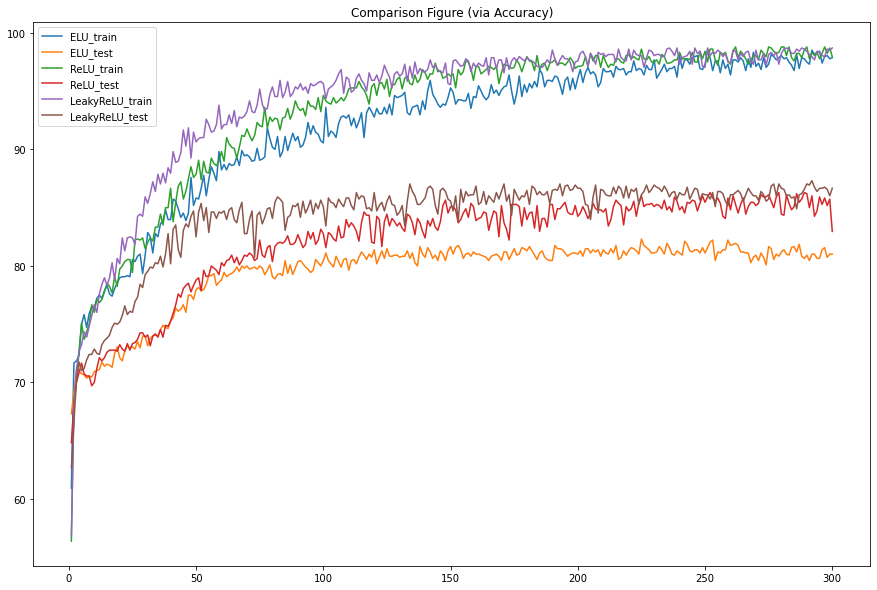

In [27]:
plot_result(df_acc)